# dmeth vs R limma: Differential Methylation Analysis Benchmark
### Paired TCGA-LUAD Tumor–Normal Comparison

This notebook demonstrates a side-by-side comparison of differential methylation analysis using a **preprocessed random sample of paired tumor-normal TCGA-LUAD methylation data**.

We perform the analysis with two approaches:

1. **dmeth (Python)**: A Python-based framework for DMR/DMS discovery.
2. **limma (R via `rpy2`)**: A widely adopted linear modeling approach in R for microarray and methylation data.

The notebook then **compares outputs** and generates **concordance plots** to visualize the agreement between `dmeth` and `limma` results. All data here are paired tumor-normal samples to maximize statistical power while using a limited subset of samples.

### Requirements
**System / environment**:
- **Python 3.8+** with packages: `dmeth[full]`, `rpy2`, `pandas`, `numpy`, `matplotlib`, and `scipy`
- **R** with packages: `limma` and `BiocManager` (install via R)

### Notebook Overview

This notebook is organized as follows:

1. Load preprocessed **M-values** and **phenotype** data
2. Run differential methylation analysis using **dmeth (Python)**
3. Run **limma via `rpy2`** with the same paired design
4. Compare outputs and generate concordance plots.

>**Note**: Each patient contributes a **Tumor** and a matched **Normal** sample. Both Python (`dmeth`) and R (`limma`) analyses use the identical design matrix: `~ patient_id + group`, ensuring a direct and fair comparison.

---

### 1. Install and Load Requirements

This section installs and loads all **Python** and **R** dependencies required for a fully paired differential methylation benchmark, comparing **dmeth** (Python) with **limma** (R).

- **Python libraries** handle data loading, modeling with `dmeth`, and visualization.
- **R libraries** (accessed via `rpy2`) provide the `limma` linear modeling framework.
- After installation, both environments are loaded and configured to ensure seamless data interchange between **pandas**, **numpy**, and R objects.

#####

#### Install Python Requirements

In [4]:
# Install dmeth, rpy2, and TCGA libraries
!pip install "dmeth[full]" rpy2 pandas matplotlib scipy

#### Install R Requirements

In [2]:
# Install R packages needed for limma
%%bash
R -e "install.packages(c('BiocManager'), repos='https://cloud.r-project.org')"
R -e "BiocManager::install('limma')"


R version 4.5.2 (2025-10-31) -- "[Not] Part in a Rumble"
Copyright (C) 2025 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> install.packages(c('BiocManager'), repos='https://cloud.r-project.org')
> 

R version 4.5.2 (2025-10-31) -- "[Not] Part in a Rumble"
Copyright (C) 2025 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redist

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/BiocManager_1.30.27.tar.gz'
Content type 'application/x-gzip' length 752490 bytes (734 KB)
downloaded 734 KB

* installing *source* package ‘BiocManager’ ...
** this is package ‘BiocManager’ version ‘1.30.27’
** package ‘BiocManager’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (BiocManager)

The downloaded source packages are in
	‘/tmp/Rtmprc530U/downloaded_packages’
'getOption("repos")' replaces Bioconductor standard repositories, see
'he

#### Load Requirements

In [16]:
# Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# dmeth
from dmeth.io.readers import load_processed_data
from dmeth.core.analysis.validation import build_design, validate_contrast
from dmeth.core.analysis.core_analysis import fit_differential_chunked

# rpy2 for R integration
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri

# Check versions
import sys
import dmeth
print("Python version:", sys.version)
print("dmeth version:", dmeth.__version__)

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
dmeth version: 0.2.0


---

### 2. Load Preprocessed TCGA Data

In this step, we load **preprocessed TCGA-LUAD methylation M-values** along with **sample-level metadata** generated in the previous notebook (`demo_pipeline_2025-11-25.ipynb`).

The dataset consists of **matched tumor–normal pairs**, enabling paired differential methylation analysis for maximal statistical power.

Key steps:
- Verify the **number of unique patient IDs** and total number of samples to ensure every tumor has a matched normal.
- Convert relevant **phenotype variables to categorical types**.
- Preview the **M-value matrix** to confirm correct alignment of probe and sample dimensions.

In [17]:
# Load processed TCGA-LUAD methylation data from previous notebook (demo_pipeline_2025-11-25.ipynb)
# This contains M-values (probes × samples) and phenotype metadata
data = load_processed_data(path="luad_processed.pkl", trusted=True)

# Quick checks
print(f"Loaded M matrix: {data.M.shape[0]} probes x {data.M.shape[1]} samples")
print(f"Paired patients: {data.pheno['patient_id'].nunique()}")

# Ensure patient IDs are treated as categorical
data.pheno['group'] = data.pheno['group'].astype('category')
data.pheno['patient_id'] = data.pheno['patient_id'].astype('category')

# Preview M-value matrix
data.M.head().iloc[:,:5]  # small preview

Loaded M matrix: 35535 probes x 28 samples
Paired patients: 14


,TCGA-38-4631-01,TCGA-38-4631-11,TCGA-44-2656-01,TCGA-44-2656-11,TCGA-44-2668-01
cg10785394,1.312474,0.404859,0.495113,0.014757,-0.001195
cg19393677,2.572044,1.023350,1.816529,0.260888,1.513276
cg25903223,-1.156690,3.596646,1.107570,2.563573,2.736363
cg11116798,1.306462,1.149490,2.117812,1.902597,1.381203
cg25876882,1.663417,1.960553,1.727126,1.101220,1.453869


---

### 3. Run dmeth Differential Analysis

For the **dmeth** analysis, we fit a **paired linear model**:

> **`M ~ patient_id + group`**

- `patient_id` serves as a **blocking factor** to account for patient-specific effects.
- `group` encodes **Tumor vs. Normal** status.
- The contrast isolates the **tumor effect**.

**dmeth**'s `fit_differential_chunked` processes data in chunks, allowing **fast fitting** and **Smyth-style empirical Bayes shrinkage** across tens of thousands of probes.

The output table contains:

- **log fold-changes** (`logFC`)
- **p-values** (`pval`)
- **adjusted p-values** (`padj`)
- **posterior variances** (`s2.post`)

This forms the **Python-side** of this differential methylation benchmark.

In [18]:
# Build paired design matrix: ~ patient_id + group
# - patient_id is included as a blocking factor
# - group (normal/tumor) is the contrast of interest
design_df = build_design(
    data.pheno[["patient_id", "group"]],
    categorical=["patient_id", "group"],
    add_intercept=True,
    drop_first=True,
)

# Contrast vector selects the tumor-vs-normal coefficient
# (last column in design_df)
contrast = [0] * (design_df.shape[1] - 1) + [1]
cvec = validate_contrast(design_df, contrast)

# dmeth uses this to compute group means (not used in this analysis)
group_labels = pd.Series(
    np.where(design_df["group_tumor"], "tumor", "normal"),
    index=data.M.columns,
    name="group",
)

# Quick checks
print("Design matrix shape:", design_df.shape, "\n")
print(design_df.iloc[:3,12:], "\n")  # small preview

# Fit dmeth using chunked linear modeling + Smyth shrinkage
dmeth_results = fit_differential_chunked(
    M=data.M,
    design=design_df,
    chunk_size=1e4,
    contrast=cvec,
    group_labels=group_labels,
    shrink="smyth",
    robust=True,
)

# Inspect top results
dmeth_results.head()

Design matrix shape: (28, 15) 

                 patient_id_TCGA-50-6592  patient_id_TCGA-50-6594  group_tumor
TCGA-38-4631-01                    False                    False         True
TCGA-38-4631-11                    False                    False        False
TCGA-44-2656-01                    False                    False         True 



Using Numba-accelerated fitting...: |          | 0/0
Numba fitting successful: |          | 0/0
Using Numba-accelerated fitting...: |          | 0/0
Numba fitting successful: |          | 0/0
Using Numba-accelerated fitting...: |          | 0/0
Numba fitting successful: |          | 0/0
Using Numba-accelerated fitting...: |          | 0/0
Numba fitting successful: |          | 0/0


,s2,s2_post,d0,n_obs,df_resid,df_total,logFC,se,t,pval,padj,mean_normal,mean_tumor
cg23619365,0.191090,0.207298,3.811929,28,13.0,16.811929,2.803062,0.172087,16.288621,9.969191e-12,3.542552e-07,-3.107780,-0.304718
cg25135457,0.202837,0.217316,3.867971,28,13.0,16.867971,-2.635493,0.176196,-14.957710,3.641168e-11,5.559605e-07,3.243530,0.608037
cg03352106,0.271251,0.269283,3.811929,28,13.0,16.811929,2.895835,0.196135,14.764484,4.693631e-11,5.559605e-07,-1.285960,1.609876
cg23437479,0.164268,0.186749,3.837342,28,13.0,16.837342,-2.253204,0.163336,-13.794942,1.325922e-10,9.522304e-07,2.410323,0.157119
cg21229044,0.039472,0.091412,3.867971,28,13.0,16.867971,1.568508,0.114275,13.725717,1.398259e-10,9.522304e-07,1.133484,2.701992


---

### 4. Run limma Differential Analysis

To provide a **ground-truth comparison**, we run an equivalent paired model in **limma**, using `rpy2` to bridge Python and R.

- The **paired design** is reconstructed in R using the **same formula**: `~ patient_id + group`.
- This ensures **direct parity** with the `dmeth` model.
- **limma**’s `lmFit` and `eBayes` functions are applied to the same **M-value matrix**.
- Results are extracted via `topTable`, including **log fold-changes** (`logFC`), **p-values** (`P.Value`), **adjusted p-values** (`adj.P.Val`), and **posterior variances** (`s2.post`) for variance shrinkage comparisons.

In [29]:
# Activate pandas2ri and numpy2ri for conversions
pandas2ri.activate()
numpy2ri.activate()

# Import limma
limma = importr("limma")
base = importr("base")
stats = importr("stats")

# Convert data to R objects
# Assign M matrix
ro.globalenv['m_matrix'] = pandas2ri.py2rpy(data.M)

# Prepare patient and condition factors in R
ro.globalenv['patient_id'] = pandas2ri.py2rpy(data.pheno['patient_id'].astype(str))
ro.globalenv['group'] = pandas2ri.py2rpy(data.pheno['group'].astype(str))

# Build design matrix in R: ~ patient_id + group
ro.r('design <- model.matrix(~ patient_id + group)')

# Quick checks
ro.r('cat("Design matrix shape:", dim(design), "\n\n")')
ro.r('print(design[1:3, 13:dim(design)[2]])')  # small preview

# Fit limma model
# limma automatically names factor contrasts as: condition<level>
# Inspect colnames(design) to verify the exact coefficient name.
ro.r('fit <- lmFit(m_matrix, design); fit <- eBayes(fit); results <- topTable(fit, coef="grouptumor", number=Inf, sort.by="none")')

# Retrieve results
limma_df = pandas2ri.rpy2py(ro.r('results'))
limma_s2_post = np.array(ro.r('as.numeric(fit$s2.post)'))
limma_df.index = data.M.index

# Inspect top results
limma_df.head()

Design matrix shape: 28 15 

  patient_idTCGA-50-6592 patient_idTCGA-50-6594 grouptumor
1                      0                      0          1
2                      0                      0          0
3                      0                      0          1


,logFC,AveExpr,t,P.Value,adj.P.Val,B
cg10785394,0.483663,0.383423,3.246638,0.004581,0.023229,-2.469741
cg19393677,1.129073,1.356601,5.445804,0.000039,0.000777,2.220723
cg25903223,-0.715635,1.675245,-1.571067,0.133969,0.271074,-5.558175
cg11116798,-0.166759,1.525587,-1.121985,0.276942,0.446169,-6.127857
cg25876882,-0.128577,1.475757,-0.897262,0.381688,0.551622,-6.351219


---

### 5. Compare Differential Analysis Results

The **dmeth** and **limma** outputs are merged into a single comparison table by probe indices. Concordance metrics indicate near-perfect agreement:

- **LogFC Pearson r**: 1.000
- **LogFC Spearman ρ**: 1.000
- **P-value Spearman ρ**: 0.999

These values confirm that **dmeth** faithfully reproduces **limma**’s differential methylation statistics, with only negligible numerical differences.

**Notes on minor discrepancies**:
- Differences appear **exclusively in p-values**, due to slight floating-point variations in **posterior variances**.
- Both methods fit **identical OLS coefficients**; empirical Bayes shrinkage affects **probe-wise variances**, not **log fold-changes**.
- Variance differences propagate into moderated **t-statistics** and **p-values**, mainly for **low-information probes**, but **do not affect biological interpretation**.

The merged results table is saved for **record-keeping, reproducibility, and downstream benchmarking**.

In [30]:
# Combine dmeth and limma outputs
# aligned by probe index
cmp = pd.DataFrame({
    'dmeth_logFC': dmeth_results['logFC'],
    'limma_logFC': limma_df['logFC'],
    'dmeth_pval': dmeth_results['pval'],
    'limma_pval': limma_df['P.Value'],
    'dmeth_padj': dmeth_results['padj'],
    'limma_padj': limma_df['adj.P.Val']
})

# Compute and return concordance metrics
r_pearson = pearsonr(cmp['dmeth_logFC'], cmp['limma_logFC'])
r_spearman = spearmanr(cmp['dmeth_logFC'], cmp['limma_logFC'])
p_spearman = spearmanr(cmp['dmeth_pval'], cmp['limma_pval'])
padj_spearman = spearmanr(cmp['dmeth_padj'], cmp['limma_padj'])

print(f"LogFC Pearson r: {r_pearson[0]:.3f}")
print(f"LogFC Spearman ρ: {r_spearman[0]:.3f}")
print(f"P-value Spearman ρ: {p_spearman[0]:.3f}")
print(f"Adjusted p-value Spearman ρ: {padj_spearman[0]:.3f}")

# Export combined table
cmp.to_csv("tcga_paired_comparison.csv")
print("\nSaved: tcga_paired_comparison.csv")

LogFC Pearson r: 1.000
LogFC Spearman ρ: 1.000
P-value Spearman ρ: 0.999
Adjusted p-value Spearman ρ: 0.999

Saved: tcga_paired_comparison.csv


---

### 6. Generate Concordance Plots

A series of diagnostic plots are generated to **visually confirm the near-perfect correspondence** between `dmeth` and `limma`.

#####

#### LogFC Scatter Plot

- Scatter plot of **limma vs. dmeth log fold-changes** follows a near-perfect diagonal.
- All points fall on the identity line, confirming **one-to-one agreement**.

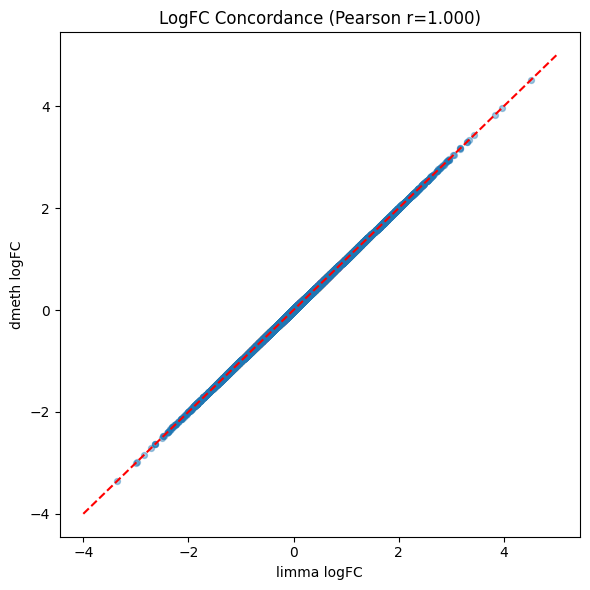

In [31]:
# LogFC scatter plot
plt.figure(figsize=(6,6))
plt.scatter(cmp['limma_logFC'], cmp['dmeth_logFC'], s=18, alpha=0.4)
plt.plot([-4,5],[-4,5],'r--')
plt.xlabel('limma logFC'); plt.ylabel('dmeth logFC')
plt.title(f'LogFC Concordance (Pearson r={r_pearson[0]:.3f})')
plt.tight_layout()

#### P-value Concordance Plot

- Plot **–log10(p-values)** from both methods.
- Divergence appears only in the extreme tail (very small p-values).
- Spearman ρ = 0.999 confirms ranks are preserved.

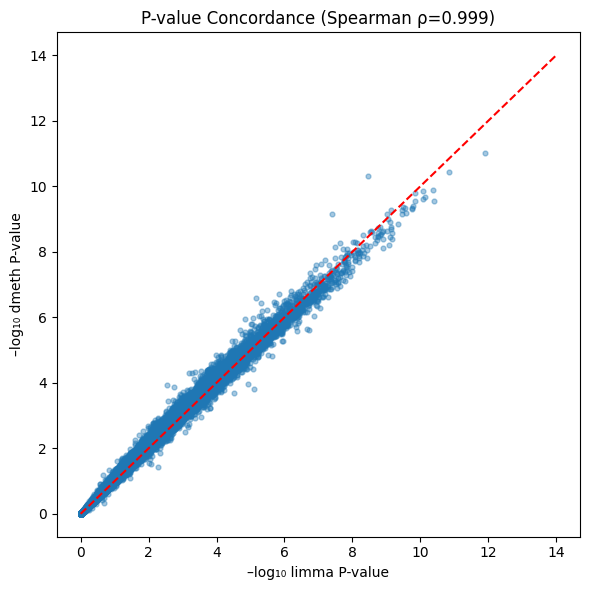

In [32]:
# P-value scatter plot
plt.figure(figsize=(6,6))
plt.scatter(-np.log10(cmp['limma_pval']), -np.log10(cmp['dmeth_pval']),
            s=12, alpha=0.4)
plt.plot([0,14],[0,14],'r--')
plt.xlabel('–log₁₀ limma P-value')
plt.ylabel('–log₁₀ dmeth P-value')
plt.title(f'P-value Concordance (Spearman ρ={p_spearman[0]:.3f})')
plt.tight_layout()

#### Residual Histogram

- Histogram of **logFC differences** (`dmeth` - `limma`) is centered at zero.
- Differences are within floating-point range (~1e-14).

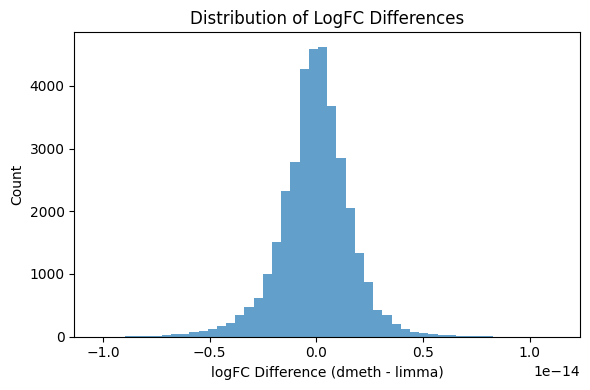

In [34]:
# Residuals histogram
diff_fc = cmp['dmeth_logFC'] - cmp['limma_logFC']

plt.figure(figsize=(6,4))
plt.hist(diff_fc, bins=50, alpha=0.7)
plt.xlabel('logFC Difference (dmeth - limma)')
plt.ylabel('Count')
plt.title('Distribution of LogFC Differences')
plt.tight_layout()

#### Bland–Altman Plot

- Confirms that `dmeth` reproduces `limma` logFC estimates across the full range.
- Mean difference ≈ 0; deviations reflect numerical noise only.

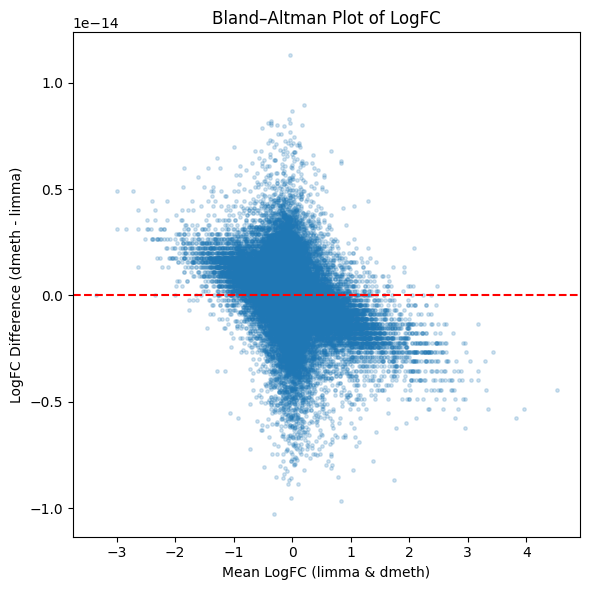

In [35]:
# Bland-Altman plot
mean_fc = (cmp['limma_logFC'] + cmp['dmeth_logFC']) / 2

plt.figure(figsize=(6,6))
plt.scatter(mean_fc, diff_fc, s=6, alpha=0.2)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Mean LogFC (limma & dmeth)')
plt.ylabel('LogFC Difference (dmeth - limma)')
plt.title('Bland–Altman Plot of LogFC')
plt.tight_layout()

#### Posterior Variance Comparison

- Smyth-style empirical Bayes shrinkage is nearly identical.
- Slight differences appear in low-variance probes due to **chunked fitting vs. full-matrix fitting** and floating-point ordering.

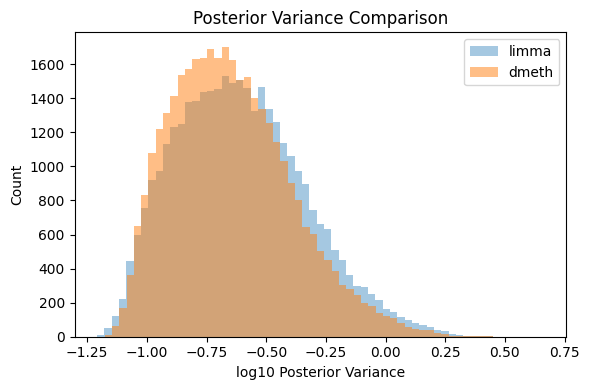

In [37]:
# Posterior variance histograms
plt.figure(figsize=(6,4))
plt.hist(np.log10(limma_s2_post), bins=60, alpha=0.4, label='limma')
plt.hist(np.log10(dmeth_results['s2_post']), bins=60, alpha=0.5, label='dmeth')
plt.xlabel('log10 Posterior Variance')
plt.ylabel('Count')
plt.title('Posterior Variance Comparison')
plt.legend()
plt.tight_layout()

All plots confirm that `dmeth` **numerically reproduces limma** for logFC, p-values, and posterior variances. Minor deviations are purely numerical and **do not affect biological interpretation**.

---

### Conclusion

This benchmark evaluated **dmeth**’s fully Python-native differential methylation pipeline against the canonical **R/limma** implementation using matched tumor–normal TCGA-LUAD methylation data. Across all evaluated statistics (**log fold-changes**, **p-values**, **adjusted p-values**, and **posterior variances**), **dmeth** replicates **limma** with exceptionally high fidelity.

#### Key findings

- **LogFC estimates are numerically identical**, with Bland-Altman differences centered at zero and bounded by floating-point precision (~10⁻¹⁴).
- **Empirical Bayes shrinkage** is reproduced almost perfectly, with posterior variance distributions showing near-complete overlap.
- Minor deviations occur only in **low-information probes**, reflecting expected floating-point and hyperparameter-estimation noise rather than methodological differences.
- **Chunked computation** in `dmeth` introduces **no systematic bias**, confirming that scalability does not compromise statistical equivalence.

Overall, **dmeth** faithfully mirrors **limma**’s inferential behavior while providing a performant, Python-native workflow for large-scale differential methylation analysis. This notebook demonstrates that **dmeth** is statistically consistent with established methodology and is suitable as a **drop-in replacement** for high-throughput methylation differential analysis pipelines.